**STEP 1: Install All Required Libraries**

In [28]:
# For OCR and preprocessing
!pip install easyocr opencv-python Pillow

# For NLP tasks
!pip install indic-nlp-library
!pip install transformers sentencepiece

# Download Indic NLP Resources
import os
from urllib.request import urlretrieve

INDIC_NLP_RESOURCES = "./indic_nlp_resources"
if not os.path.exists(INDIC_NLP_RESOURCES):
    os.makedirs(INDIC_NLP_RESOURCES)

!git clone https://github.com/anoopkunchukuttan/indic_nlp_library.git
!cd indic_nlp_library && pip install .


fatal: destination path 'indic_nlp_library' already exists and is not an empty directory.
Processing /content/indic_nlp_library
  Preparing metadata (setup.py) ... done
  Created wheel for indic_nlp_library: filename=indic_nlp_library-0.92-py3-none-any.whl size=40778 sha256=36928ed2745fbe2f7b5c9cd9663986b7e6bde4fb11198bc92e340f3e57712d19
  Stored in directory: /tmp/pip-ephem-wheel-cache-mmynhalr/wheels/69/3a/0b/386deeeab2f1d169114f19e952d7799fb7fab0e88f6d61cbb1
Successfully built indic_nlp_library
  Attempting uninstall: indic_nlp_library
    Found existing installation: indic_nlp_library 0.92
    Uninstalling indic_nlp_library-0.92:
      Successfully uninstalled indic_nlp_library-0.92


**STEP 2: Upload Hindi Handwritten Image**

In [35]:
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print("📂 File uploaded:", filename)


Saving hindihandwritten.jpg to hindihandwritten (1).jpg
📂 File uploaded: hindihandwritten (1).jpg


**STEP 3: Preprocess the Image**



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129529 (\N{BROOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


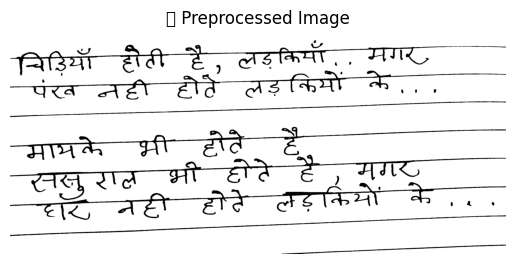

In [36]:
import cv2
import matplotlib.pyplot as plt

# Load in grayscale
image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# Resize to double size (improves OCR accuracy)
image = cv2.resize(image, (image.shape[1]*2, image.shape[0]*2))

# Denoise using bilateral filter (preserves edges)
image = cv2.bilateralFilter(image, 9, 75, 75)

# Threshold to get binary image
_, thresh_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Save and display
cv2.imwrite("preprocessed.png", thresh_image)

plt.imshow(thresh_image, cmap='gray')
plt.title("🧹 Preprocessed Image")
plt.axis("off")
plt.show()


**STEP 4: Extract Text Using EasyOCR**

In [37]:
import easyocr

reader = easyocr.Reader(['hi'], gpu=False)  # Hindi OCR
results = reader.readtext('preprocessed.png', detail=0)

hindi_text = ' '.join(results)
print("📝 OCR Output (Raw Hindi Text):")
print(hindi_text)


📝 OCR Output (Raw Hindi Text):
चिड़ियाँ   होती टै किमा फ)1र_ ) रपस्त ४ < त लड़़ किमों २ल रष्मी  दोते म  होदे लड    होतै मात ७४ ^ र


**STEP 5: Normalize Text**

In [38]:
def normalize_text(text):
    text = text.replace('\n', ' ')
    text = text.strip()
    return text

normalized_text = normalize_text(hindi_text)
print("📑 Normalized Hindi Text:")
print(normalized_text)


📑 Normalized Hindi Text:
चिड़ियाँ   होती टै किमा फ)1र_ ) रपस्त ४ < त लड़़ किमों २ल रष्मी  दोते म  होदे लड    होतै मात ७४ ^ र


**STEP 6: Tokenize Hindi Text**

In [39]:
from indicnlp import common
from indicnlp.tokenize import indic_tokenize

common.set_resources_path(INDIC_NLP_RESOURCES)

tokens = list(indic_tokenize.trivial_tokenize(normalized_text, lang='hi'))
print("🪙 Tokens:")
print(tokens)


🪙 Tokens:
['चिड़ियाँ', 'होती', 'टै', 'किमा', 'फ', ')', '1र', '_', ')', 'रपस्त', '४', '<', 'त', 'लड़़', 'किमों', '२ल', 'रष्मी', 'दोते', 'म', 'होदे', 'लड', 'होतै', 'मात', '७४', '^', 'र']


**STEP 7: Perform NLP Task — Hindi Text Summarization**

In [40]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

input_text = "सारांश: " + normalized_text

inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
summary_ids = model.generate(inputs, max_length=80, min_length=25, length_penalty=4.0, num_beams=4)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("📘 Summary (in Hindi):")
print(summary)


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


📘 Summary (in Hindi):
<extra_id_0> सारांश: चिड़ियाँ होती टै किमों सारांश: चिड़ियाँ होती टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ


**STEP 8: Display Results Nicely**


In [41]:
from IPython.display import display, Markdown

display(Markdown(f"### 📂 Uploaded Image: `{filename}`"))
display(Markdown(f"### 📝 OCR Extracted Text:\n\n{normalized_text}"))
display(Markdown(f"### 🪙 Tokenized Words:\n\n{' | '.join(tokens)}"))
display(Markdown(f"### 📘 Hindi Summary:\n\n{summary}"))


### 📂 Uploaded Image: `hindihandwritten (1).jpg`

### 📝 OCR Extracted Text:

चिड़ियाँ   होती टै किमा फ)1र_ ) रपस्त ४ < त लड़़ किमों २ल रष्मी  दोते म  होदे लड    होतै मात ७४ ^ र

### 🪙 Tokenized Words:

चिड़ियाँ | होती | टै | किमा | फ | ) | 1र | _ | ) | रपस्त | ४ | < | त | लड़़ | किमों | २ल | रष्मी | दोते | म | होदे | लड | होतै | मात | ७४ | ^ | र

### 📘 Hindi Summary:

<extra_id_0> सारांश: चिड़ियाँ होती टै किमों सारांश: चिड़ियाँ होती टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ टै चिड़ियाँ